<a href="https://colab.research.google.com/github/MinsooKwak/segmentation/blob/main/human_segmentation/human_segmentation_with_mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- kaggle의 Human Segmentation Dataset을 활용
  - 링크 : https://www.kaggle.com/datasets/tapakah68/supervisely-filtered-segmentation-person-dataset/data
  - 사람에 대한 마스크 기반 segmentation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

## 1. 데이터셋

- segmentation의 경우 png는 어그러질 수 있기 때문에 png 또는 array 형식이 좋음

In [3]:
data_dir = '/content/drive/MyDrive/DataSet/human_segmentation/'
data_df = pd.read_csv(os.path.join(data_dir, "df.csv"))
data_df.head()

,Unnamed: 0,images,masks,collages
0,0,images/ds10_pexels-photo-687782.png,masks/ds10_pexels-photo-687782.png,collage/ds10_pexels-photo-687782.jpg
1,1,images/ds10_pexels-photo-835971.png,masks/ds10_pexels-photo-835971.png,collage/ds10_pexels-photo-835971.jpg
2,2,images/ds10_pexels-photo-850708.png,masks/ds10_pexels-photo-850708.png,collage/ds10_pexels-photo-850708.jpg
3,3,images/ds10_pexels-photo-864937.png,masks/ds10_pexels-photo-864937.png,collage/ds10_pexels-photo-864937.jpg
4,4,images/ds10_pexels-photo-865908.png,masks/ds10_pexels-photo-865908.png,collage/ds10_pexels-photo-865908.jpg


In [4]:
df = data_df[['images','masks']]
df.head(3)

,images,masks
0,images/ds10_pexels-photo-687782.png,masks/ds10_pexels-photo-687782.png
1,images/ds10_pexels-photo-835971.png,masks/ds10_pexels-photo-835971.png
2,images/ds10_pexels-photo-850708.png,masks/ds10_pexels-photo-850708.png


In [5]:
df.shape

(2667, 2)

In [6]:
def extract_ds_id(x):
  return x.split("/")[1].split("_")[0]

def extract_class(x):
  return x.split('_')[1].split('.png')[0]

df['ds_id'] = df['images'].apply(lambda x:extract_ds_id(x))
df['image_classes'] = df['images'].apply(lambda x:extract_class(x))

<ipython-input-6-e98143bb8e25>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ds_id'] = df['images'].apply(lambda x:extract_ds_id(x))


In [7]:
df.head(3)

,images,masks,ds_id,image_classes
0,images/ds10_pexels-photo-687782.png,masks/ds10_pexels-photo-687782.png,ds10,pexels-photo-687782
1,images/ds10_pexels-photo-835971.png,masks/ds10_pexels-photo-835971.png,ds10,pexels-photo-835971
2,images/ds10_pexels-photo-850708.png,masks/ds10_pexels-photo-850708.png,ds10,pexels-photo-850708


<Axes: xlabel='count', ylabel='ds_id'>

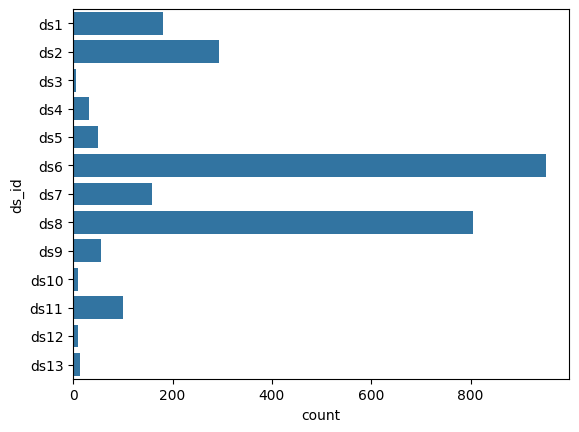

In [8]:
hue_name = ['ds1','ds2','ds3','ds4','ds5','ds6','ds7','ds8','ds9','ds10','ds11','ds12','ds13']
sns.countplot(df['ds_id'],order=hue_name)

- 정확히 모든 class를 함축하진 않지만 대략적 파악을 위해 전처리
- '-'를 통해 클래스 구분되어 있고, 일부는 같은 클래스를 포함하고 있음
- 수식하는 표현이 포함되어 주의
- 리스트를 통한 클래스 추출 및 count도 가능할 것

In [9]:
import re

def no_number_class(x):
  x = x.split('_')[1]
  x = x.split('.png')[0]
  x = re.sub(r'\d','',x)
  x = x[:-1]
  return x

df['no_num_classes'] = df['images'].apply(lambda x:no_number_class(x))
df.head(3)

,images,masks,ds_id,image_classes,no_num_classes
0,images/ds10_pexels-photo-687782.png,masks/ds10_pexels-photo-687782.png,ds10,pexels-photo-687782,pexels-photo
1,images/ds10_pexels-photo-835971.png,masks/ds10_pexels-photo-835971.png,ds10,pexels-photo-835971,pexels-photo
2,images/ds10_pexels-photo-850708.png,masks/ds10_pexels-photo-850708.png,ds10,pexels-photo-850708,pexels-photo


In [10]:
df.ds_id.value_counts()

ds6     951
ds8     805
ds2     293
ds1     181
ds7     159
ds11    100
ds9      57
ds5      50
ds4      31
ds13     14
ds10     10
ds12     10
ds3       6
Name: ds_id, dtype: int64

In [11]:
class_count_df = pd.DataFrame(df['no_num_classes'].value_counts())
class_count_df

,no_num_classes
pexels-photo,2263
girl-lake-dress-white,4
people-man-model-glasses,3
colors-hairdresser-cutting-colorimetry,3
adult-black-body-costume,3
...,...
black-fashion-fashion-model-model,1
black-and-white-person-feeling-smilin,1
bezel-hairstyle-man-mode,1
beauty-woman-flowered-hat-cap,1


In [12]:
condition_pixel_photo = (df['no_num_classes'] == 'pexels-photo')
df_pixel_photo = df[condition_pixel_photo]
df_pixel_photo

,images,masks,ds_id,image_classes,no_num_classes
0,images/ds10_pexels-photo-687782.png,masks/ds10_pexels-photo-687782.png,ds10,pexels-photo-687782,pexels-photo
1,images/ds10_pexels-photo-835971.png,masks/ds10_pexels-photo-835971.png,ds10,pexels-photo-835971,pexels-photo
2,images/ds10_pexels-photo-850708.png,masks/ds10_pexels-photo-850708.png,ds10,pexels-photo-850708,pexels-photo
3,images/ds10_pexels-photo-864937.png,masks/ds10_pexels-photo-864937.png,ds10,pexels-photo-864937,pexels-photo
4,images/ds10_pexels-photo-865908.png,masks/ds10_pexels-photo-865908.png,ds10,pexels-photo-865908,pexels-photo
...,...,...,...,...,...
2662,images/ds9_pexels-photo-884417.png,masks/ds9_pexels-photo-884417.png,ds9,pexels-photo-884417,pexels-photo
2663,images/ds9_pexels-photo-884418.png,masks/ds9_pexels-photo-884418.png,ds9,pexels-photo-884418,pexels-photo
2664,images/ds9_pexels-photo-884419.png,masks/ds9_pexels-photo-884419.png,ds9,pexels-photo-884419,pexels-photo
2665,images/ds9_pexels-photo-884421.png,masks/ds9_pexels-photo-884421.png,ds9,pexels-photo-884421,pexels-photo


In [13]:
df_non_pixel_photo = df[~condition_pixel_photo]
df_non_pixel_photo

,images,masks,ds_id,image_classes,no_num_classes
9,images/ds10_thailand-costume-girl-woman-157857...,masks/ds10_thailand-costume-girl-woman-157857.png,ds10,thailand-costume-girl-woman-157857,thailand-costume-girl-woman
10,images/ds11_adorable-baby-beautiful-boy-41000.png,masks/ds11_adorable-baby-beautiful-boy-41000.png,ds11,adorable-baby-beautiful-boy-41000,adorable-baby-beautiful-boy
11,images/ds11_autumn-fall-baby-boy-child-59865.png,masks/ds11_autumn-fall-baby-boy-child-59865.png,ds11,autumn-fall-baby-boy-child-59865,autumn-fall-baby-boy-child
12,images/ds11_baby-boy-child-christmas-41173.png,masks/ds11_baby-boy-child-christmas-41173.png,ds11,baby-boy-child-christmas-41173,baby-boy-child-christmas
13,images/ds11_baby-boy-hat-covered-101537.png,masks/ds11_baby-boy-hat-covered-101537.png,ds11,baby-boy-hat-covered-101537,baby-boy-hat-covered
...,...,...,...,...,...
2605,images/ds8_women-sexy-outdoors-girl-48843.png,masks/ds8_women-sexy-outdoors-girl-48843.png,ds8,women-sexy-outdoors-girl-48843,women-sexy-outdoors-girl
2606,images/ds8_women-young-gorgeous-lying-47362.png,masks/ds8_women-young-gorgeous-lying-47362.png,ds8,women-young-gorgeous-lying-47362,women-young-gorgeous-lying
2607,images/ds8_young-girl-pretty-beauty-52990.png,masks/ds8_young-girl-pretty-beauty-52990.png,ds8,young-girl-pretty-beauty-52990,young-girl-pretty-beauty
2608,images/ds8_young-woman-pretty-shooting-157717.png,masks/ds8_young-woman-pretty-shooting-157717.png,ds8,young-woman-pretty-shooting-157717,young-woman-pretty-shooting


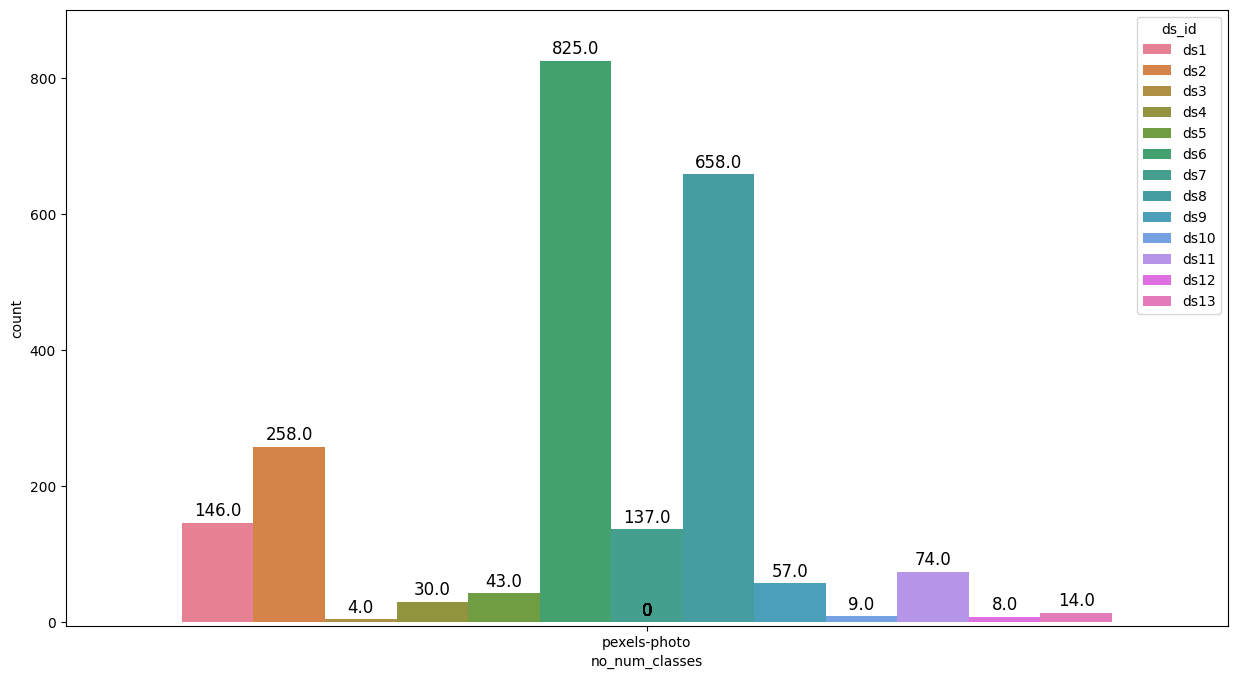

In [14]:
plt.figure(figsize=(15,8))
ax = sns.countplot(data=df_pixel_photo, x = df_pixel_photo['no_num_classes'], hue=df_pixel_photo['ds_id'],hue_order=hue_name)

for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x() + p.get_width()/2., height+10, height, ha='center', size=12)

ax.set_ylim(-5,900)
plt.show()

In [15]:
strings_1 = 'images/ds10_pexels-photo-687782.png'
strings_1.split('/')[1]

'ds10_pexels-photo-687782.png'

In [16]:
data_dir

'/content/drive/MyDrive/DataSet/human_segmentation/'

In [17]:
path_ids_data = df[['images','masks']]

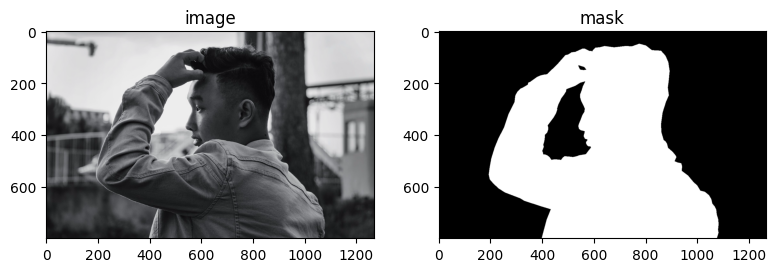

In [18]:
sub_index = 5
img_name, mask_name = path_ids_data.iloc[sub_index].values

img_path = os.path.join(data_dir, img_name)
mask_path = os.path.join(data_dir,mask_name)

image = cv2.imread(img_path)
mask = cv2.imread(mask_path)

# jpeg일 경우
  # thres = 240
  # mask[mask < thres] = 0
  # mask[mask > thres] = 255

plt.figure(figsize=(8,6))
plt.subplot(121)
plt.title('image')
plt.imshow(image)

plt.subplot(122)
plt.title('mask')
plt.imshow(mask)
plt.tight_layout()

In [19]:
mask.shape

(800, 1267, 3)

In [ ]:
#plt.imshow(mask[..., 0])  # 여러개 있을 때 0, 1, 2 등 확인 가능

In [20]:
np.unique(mask)

array([  0, 255], dtype=uint8)

In [21]:
# 클래스 여러개 있을 때
seg_region = ['background','people']
colors = ((0,0,0),(255,255,255))

### 데이터셋 구축 및 텐서 변환 모듈 작성

In [22]:
import torch

In [23]:
data_dir

'/content/drive/MyDrive/DataSet/human_segmentation/'

In [ ]:
#!pip install split-folders[full]

In [ ]:
#import splitfolders

In [ ]:
# data split (train:val:test) # train : val로만 나눌 경우 2개 인자만 입력
#splitfolders.ratio(input=data_dir, output = "/content/drive/MyDrive/DataSet/human_segmentation_split", seed =2024, ratio=(0.8,0.2))

Copying files: 8001 files [17:06,  7.79 files/s]


In [24]:
data_dir2 = "/content/drive/MyDrive/DataSet/human_segmentation_split"



```
data_dir
  ㄴ images  : *.png
  ㄴ masks   : *.png
```



In [25]:
IMAGE_SIZE =224

In [26]:
class human_dataset():
  def __init__(self, data_dir, phase, transformer=None):
    self.phase = phase                                    # phase : train, eval, test mode
    self.images_dir = os.path.join(data_dir, phase, "images")
    self.masks_dir = os.path.join(data_dir, phase, "masks")
    # listdir 내 파일들을 확장자가 png이면 list로
    self.image_files = [filename for filename in os.listdir(self.images_dir) if filename.endswith("png")]
    self.mask_files = [filename for filename in os.listdir(self.masks_dir) if filename.endswith("png")]
    assert len(self.image_files) == len(self.mask_files)

    self.transformer = transformer

  def __len__(self,):
    return len(self.image_files)

  def __getitem__(self, index):
    image = cv2.imread(os.path.join(self.images_dir, self.image_files[index]))
    image = cv2.resize(image, dsize=(IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_LINEAR)
    # mask의 경우 resize 할 때 근접 픽셀로 값 채우는 비선형 방식으로 resize 필요
    mask = cv2.imread(os.path.join(self.masks_dir, self.mask_files[index]))
    mask = cv2.resize(mask, dsize=(IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)

    # 뭉게진 부분 처리
    mask[mask < 240] = 0
    mask[mask >=240] = 255
    mask = mask/255. # (0~1)

    mask_H, mask_W, mask_C = mask.shape
    background = np.ones(shape = (mask_H, mask_W))
    background[mask[..., 0] != 0] = 0 # background에 대한 target 별도 지정
    background[mask[..., 1] != 0] = 0 # 아무것도 아닌 영역은 다 0으로
    background[mask[..., 2] != 0] = 0
    mask = np.concatenate([np.expand_dims(background, axis=-1), mask], axis=-1)
    mask = np.argmax(mask, axis=-1, keepdims=False)

    if self.transformer :
      image = self.transformer(image)

    # 마스크의 경우 torch 변환 필요, pixel 단위로 integer 형태로 변환
    target = torch.from_numpy(mask).long()
    return image, target

In [27]:
from torchvision import transforms

def build_transformer():
  transformer = transforms.Compose([
      transforms.ToTensor(), # 0~1로 normalize
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # imagenet의 mean, std
  ])
  return transformer

In [28]:
def collate_fn(batch):
  '''
  dataloader에 들어갈 부분
  edge 형태로 데이터가 구성될 때 개별 이미지, 라벨 데이터셋을 어떻게 minibatch 형태로 구성할지'''
  images = []
  targets = []
  for a, b in batch:
    images.append(a)
    targets.append(b)
  images = torch.stack(images, dim=0)
  targets = torch.stack(targets, dim=0)
  return images, targets

In [29]:
data_dir2

'/content/drive/MyDrive/DataSet/human_segmentation_split'

In [30]:
transformer = build_transformer()
dset = human_dataset(data_dir=data_dir2, phase='train', transformer=transformer)

In [31]:
dset[0]

(tensor([[[-1.2788, -1.2103, -1.2788,  ..., -1.5528, -1.5870, -1.5528],
          [-1.3130, -1.2274, -1.2445,  ..., -1.5699, -1.5357, -1.5014],
          [-1.3130, -1.2617, -1.2445,  ..., -1.5870, -1.5870, -1.5185],
          ...,
          [-1.5185, -1.5699, -1.5185,  ..., -1.6727, -1.7412, -1.5699],
          [-1.5185, -1.5699, -1.5870,  ..., -1.6727, -1.7583, -1.5528],
          [-1.5185, -1.5357, -1.5699,  ..., -1.6898, -1.7412, -1.6384]],
 
         [[-1.3529, -1.3004, -1.3354,  ..., -1.5455, -1.5805, -1.5280],
          [-1.3704, -1.3004, -1.3004,  ..., -1.5455, -1.5280, -1.4930],
          [-1.3880, -1.3179, -1.3004,  ..., -1.5630, -1.5630, -1.5280],
          ...,
          [-1.5105, -1.5455, -1.5105,  ..., -1.6506, -1.6856, -1.5455],
          [-1.5280, -1.5455, -1.5805,  ..., -1.6506, -1.7031, -1.5280],
          [-1.5280, -1.5455, -1.5630,  ..., -1.6681, -1.6856, -1.6155]],
 
         [[-1.1944, -1.1421, -1.1770,  ..., -1.3339, -1.3687, -1.3164],
          [-1.2119, -1.1247,

In [32]:
image , target = dset[0]
print(f'Image  shape : {image.shape}')  # C, H, W
print(f'target shape : {target.shape}') # 이미지 크기

Image  shape : torch.Size([3, 224, 224])
target shape : torch.Size([224, 224])


In [33]:
target.unique() # background index, 1번 클래스 id값

tensor([0, 1])

In [34]:
from torch.utils.data import DataLoader

In [35]:
dloader = DataLoader(dset, batch_size=4, shuffle=True, collate_fn=collate_fn)

In [36]:
for index, batch in enumerate(dloader):
  images = batch[0]
  targets = batch[1]
  print(f'Images shape : {images.shape}')   # [3,244,244] 형태의 tensor형 image가 4개 들어가 0번에 stack
  print(f'targets shape : {targets.shape}')

  if index ==0:
    break

Images shape : torch.Size([4, 3, 224, 224])
targets shape : torch.Size([4, 224, 224])


In [37]:
def build_dataloader(data_dir, batch_size=4):
  transformer = build_transformer()

  dataloaders = {}  # key값으로 다르게 동작할 수 있도록 dictionary 형태로
  train_dataset = human_dataset(data_dir=data_dir2, phase='train', transformer=transformer)
  dataloaders['train'] = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

  val_dataset = human_dataset(data_dir=data_dir2, phase='val', transformer=transformer)
  dataloaders['val'] = DataLoader(train_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
  return dataloaders

In [38]:
dataloaders = build_dataloader(data_dir=data_dir2)

In [39]:
for phase in ['train','val']: # train loader한 번, validation loader 한 번
  for index, batch in enumerate(dataloaders[phase]):
    images = batch[0]
    targets = batch[1]
    print(f'Images  shape : {images.shape}')
    print(f'targets shape : {targets.shape}')

    if index ==0:
      break

Images  shape : torch.Size([4, 3, 224, 224])
targets shape : torch.Size([4, 224, 224])
Images  shape : torch.Size([1, 3, 224, 224])
targets shape : torch.Size([1, 224, 224])


## U-Net

- Encoder 구현

In [40]:
import torch
import torch.nn as nn

In [41]:
def ConvLayer(in_channels, out_channels):
    layers = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),

        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )
    return layers

In [42]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = ConvLayer(in_channels=3, out_channels=64)
        self.conv_block2 = ConvLayer(in_channels=64, out_channels=128)
        self.conv_block3 = ConvLayer(in_channels=128, out_channels=256)
        self.conv_block4 = ConvLayer(in_channels=256, out_channels=512)
        self.conv_block5 = ConvLayer(in_channels=512, out_channels=1024)
        self.pool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        encode_features = []
        out = self.conv_block1(x)
        encode_features.append(out)
        out = self.pool(out)

        out = self.conv_block2(out)
        encode_features.append(out)
        out = self.pool(out)

        out = self.conv_block3(out)
        encode_features.append(out)
        out = self.pool(out)

        out = self.conv_block4(out)
        encode_features.append(out)
        out = self.pool(out)

        out = self.conv_block5(out)
        return out, encode_features

- encoder 잘 동작 여부 확인

In [43]:
encoder = Encoder()
x = torch.randn(1, 3, 224, 224)
out, ftrs = encoder(x)

In [44]:
for ftr in ftrs:
  print(ftr.shape)
print(out.shape)

torch.Size([1, 64, 224, 224])
torch.Size([1, 128, 112, 112])
torch.Size([1, 256, 56, 56])
torch.Size([1, 512, 28, 28])
torch.Size([1, 1024, 14, 14])


- Decoder 구현

In [45]:
def UpConvLayer(in_channels, out_channels):
    layers = nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
    return layers

In [46]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.upconv_layer1 = UpConvLayer(in_channels=1024, out_channels=512)
        self.conv_block1 = ConvLayer(in_channels=512+512, out_channels=512)

        self.upconv_layer2 = UpConvLayer(in_channels=512, out_channels=256)
        self.conv_block2 = ConvLayer(in_channels=256+256, out_channels=256)

        self.upconv_layer3 = UpConvLayer(in_channels=256, out_channels=128)
        self.conv_block3 = ConvLayer(in_channels=128+128, out_channels=128)

        self.upconv_layer4 = UpConvLayer(in_channels=128, out_channels=64)
        self.conv_block4 = ConvLayer(in_channels=64+64, out_channels=64)

    def forward(self, x, encoder_features):
        out = self.upconv_layer1(x)
        croped_enc_feature = self._center_crop(encoder_features[-1], out.shape[2:])
        out = torch.cat([out, croped_enc_feature], dim=1)
        out = self.conv_block1(out)

        out = self.upconv_layer2(out)
        croped_enc_feature = self._center_crop(encoder_features[-2], out.shape[2:])
        out = torch.cat([out, croped_enc_feature], dim=1)
        out = self.conv_block2(out)

        out = self.upconv_layer3(out)
        croped_enc_feature = self._center_crop(encoder_features[-3], out.shape[2:])
        out = torch.cat([out, croped_enc_feature], dim=1)
        out = self.conv_block3(out)

        out = self.upconv_layer4(out)
        croped_enc_feature = self._center_crop(encoder_features[-4], out.shape[2:])
        out = torch.cat([out, croped_enc_feature], dim=1)
        out = self.conv_block4(out)
        return out

    def _center_crop(self, encoder_feature, decoder_feature_size):
        croped_features = transforms.CenterCrop(size=decoder_feature_size)(encoder_feature)
        return croped_features

In [47]:
encoder = Encoder()
decoder = Decoder()
x = torch.randn(1,3,244,244)
out, ftrs = encoder(x)
out = decoder(out, ftrs)

In [48]:
print(out.shape)

torch.Size([1, 64, 240, 240])


In [49]:
import torch.nn.functional as F

In [50]:
class UNet(nn.Module):
    def __init__(self, num_classes, retain_input_dim=True):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.head = nn.Conv2d(64, num_classes, kernel_size=1)
        self.retain_input_dim = retain_input_dim

    def forward(self, x):
        out, encode_features = self.encoder(x)
        out = self.decoder(out, encode_features)
        out = self.head(out)
        if self.retain_input_dim:
            _, _, H, W = x.shape
            out = F.interpolate(out, size=(H,W))
        return out

In [51]:
model = UNet(num_classes=2)
x = torch.randn(1, 3, 224, 224)
out = model(x)
print(f"input shape: {x.shape}")
print(f"output shape: {out.shape}")

input shape: torch.Size([1, 3, 224, 224])
output shape: torch.Size([1, 2, 224, 224])


## Loss

- 혼합형으로 사용해 학습할 것
  - Dice coefficient Loss
  - Cross entropy Loss

### Dice similarity coefficient (Dice coefficient)

- binary segmentation task에서 F1-score와 동일
- 이점 : Precision와 Recall을 고려할 수 있음

- DC = 2 * (Pred 합 GT) / (Pred) + (GT)

- Dice = 2|A교B| / (|A|+|B|) = 2TP / (2TP =FP +FN) == (Precision * Recall) * (Precision + Recall)

### Dice coefficient Loss

- Dice coefficient Loss = 1 - Dice coefficient

In [52]:
for index, batch in enumerate(dataloaders["train"]):
  images = batch[0]
  targets = batch[1]
  predictions = model(images)

  if index ==0:
    break

In [53]:
targets.shape

torch.Size([4, 224, 224])

In [54]:
predictions.shape

torch.Size([4, 2, 224, 224])

In [55]:
# one-hot encoding
predictions_ = torch.argmax(predictions, dim=1) # output channel의 가장 큰 value를 prediction 값으로
predictions_.shape

torch.Size([4, 224, 224])



```
# one-hot
1 -> [0, 1, 0, 0]
2 -> [0, 0, 1, 0]
```



In [56]:
onehot_pred = F.one_hot(predictions_, num_classes=2)
onehot_pred.shape

torch.Size([4, 224, 224, 2])

In [57]:
onehot_pred = onehot_pred.permute(0,3,1,2) # output channel 차원을 spatial resolution보다 앞에, batch는 첫번째
onehot_target =  F.one_hot(targets, num_classes=2).permute(0,3,1,2)

In [58]:
onehot_target.shape # B, output channel, spatial resolution

torch.Size([4, 2, 224, 224])

In [59]:
num_classes = 2

In [60]:
# batch 하나만 진행
onehot_pred_ = onehot_pred[0]
onehot_target_ = onehot_target[0]

dice_coeff = 0
for class_index in range(0,num_classes):
  A = onehot_pred_[class_index]   # 1번 영역 prediction 영역 A
  B = onehot_target_[class_index] # 1번 영역 타겟을 B
  set_inter = torch.dot(A.reshape(-1).float(), B.reshape(-1).float())
  set_sum = A.sum() + B.sum()
  dice_coeff += (2 * set_inter) / (set_sum + 1e-8)

dice_coeff /= (num_classes -1)

In [61]:
dice_coeff

tensor(0.8471)

In [62]:
dice_loss = 1 - dice_coeff
dice_loss

tensor(0.1529)

In [63]:
class UNet_metric():
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.CE_loss = nn.CrossEntropyLoss(reduction="mean")

    def __call__(self, pred, target):
        loss1 = self.CE_loss(pred, target)
        onehot_pred = F.one_hot(torch.argmax(pred, dim=1), num_classes=self.num_classes).permute(0, 3, 1, 2)
        onehot_target = F.one_hot(target, num_classes=self.num_classes).permute(0, 3, 1, 2)
        loss2 = self._get_dice_loss(onehot_pred, onehot_target)
        loss = loss1 + loss2

        dice_coefficient = self._get_batch_dice_coefficient(onehot_pred, onehot_target)
        return loss, dice_coefficient

    def _get_dice_coeffient(self, pred, target):
        set_inter = torch.dot(pred.reshape(-1).float(), target.reshape(-1).float())
        set_sum = pred.sum() + target.sum()
        # 예외사항 (예측, target 클래스 없다)
        if set_sum.item() == 0:
            set_sum = 2 * set_inter # loss 0으로 만들어 학습하지 않도록
        dice_coeff = (2 * set_inter) / (set_sum + 1e-9)
        return dice_coeff

    def _get_multiclass_dice_coefficient(self, pred, target):
        dice = 0
        for class_index in range(1, self.num_classes):
            dice += self._get_dice_coeffient(pred[class_index], target[class_index])
        return dice / (self.num_classes - 1)

    def _get_batch_dice_coefficient(self, pred, target):
        num_batch = pred.shape[0]
        dice = 0
        for batch_index in range(num_batch):
            dice += self._get_multiclass_dice_coefficient(pred[batch_index], target[batch_index])
        return dice / num_batch

    def _get_dice_loss(self, pred, target):
        return 1 - self._get_batch_dice_coefficient(pred, target)

In [64]:
criterion = UNet_metric(num_classes=2)
criterion(predictions, targets)

(tensor(1.4142, grad_fn=<AddBackward0>), tensor(0.3119))

In [65]:
for index, batch in enumerate(dataloaders["train"]):
  images = batch[0]
  targets = batch[1]
  predictions = model(images)
  loss, dice_coeff = criterion(predictions, targets)
  print(f'loss: {loss:.4f}, dice coeff: {dice_coeff:.4f}')

  if index ==0:
    break

loss: 1.3797, dice coeff: 0.3450


In [66]:
loss.backward()

- backward 위한 optimizer 정의

In [67]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [68]:
optimizer.step()

## Segmentation 학습 위한 코드 작성

In [69]:
def train_one_epoch(dataloaders, model, optimizer, criterion, device):
    losses = {}
    dice_coefficients = {}

    for phase in ["train", "val"]:
        running_loss = 0.0
        running_dice_coeff = 0.0

        if phase == "train":
            model.train()
        else:
            model.eval()

        for index, batch in enumerate(dataloaders[phase]):
            images = batch[0].to(device)
            targets = batch[1].to(device)

            with torch.set_grad_enabled(phase == "train"):
                predictions = model(images)
                loss, dice_coefficient = criterion(predictions, targets)

                if phase == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item()
            running_dice_coeff += dice_coefficient.item()

            if phase == "train":
                if index % 100 == 0:
                    text = f"{index}/{len(dataloaders[phase])}" + \
                            f" - Running Loss: {loss.item():.4f}" + \
                            f" - Running Dice: {dice_coefficient.item():.4f}"
                    print(text)

        losses[phase] = running_loss / len(dataloaders[phase])
        dice_coefficients[phase] = running_dice_coeff / len(dataloaders[phase])
    return losses, dice_coefficients

In [70]:
data_dir2

'/content/drive/MyDrive/DataSet/human_segmentation_split'

In [71]:
is_cuda = True

num_classes=2
IMAGE_SIZE = 224
BATCH_SIZE = 12
DEVICE = torch.device('cuda' if torch.cuda.is_available() and is_cuda else 'cpu')

dataloaders = build_dataloader(data_dir2, batch_size=BATCH_SIZE)
model = UNet(num_classes=num_classes)
model = model.to(DEVICE)
criterion = UNet_metric(num_classes=num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
'''
def save_model(model_state, model_name, save_dir='./trained_model'):
  os.makedirs(save_dir, exist_ok=True)
  torch.save(model_state, os.path.join(save_dir, model.name))
'''

In [72]:
num_epochs = 10

best_epoch = 0
best_score = 0.0
train_loss, train_dice_coefficient = [], []
val_loss, val_dice_coefficient = [], []

for epoch in range(num_epochs):
    losses, dice_coefficients = train_one_epoch(dataloaders, model, optimizer, criterion, DEVICE)
    train_loss.append(losses["train"])
    val_loss.append(losses["val"])
    train_dice_coefficient.append(dice_coefficients["train"])
    val_dice_coefficient.append(dice_coefficients["val"])

    print(f"{epoch}/{num_epochs} - Train Loss: {losses['train']:.4f}, Val Loss: {losses['val']:.4f}")
    print(f"{epoch}/{num_epochs} - Train Dice Coeff: {dice_coefficients['train']:.4f}, Val Dice Coeff: {dice_coefficients['val']:.4f}")

    if (epoch > 3) and (dice_coefficients["val"] > best_score):
        best_epoch = epoch
        best_score = dice_coefficients["val"]
        torch.save(model.state_dict(), f"model_{epoch:02d}.pth")

print(f"Best epoch: {best_epoch} -> Best Dice Coeffient: {best_score:.4f}")

0/178 - Running Loss: 1.3672 - Running Dice: 0.3580
100/178 - Running Loss: 1.4353 - Running Dice: 0.1540
0/10 - Train Loss: 1.4514, Val Loss: 1.4773
0/10 - Train Dice Coeff: 0.1667, Val Dice Coeff: 0.1160
0/178 - Running Loss: 1.5345 - Running Dice: 0.0832
100/178 - Running Loss: 1.2499 - Running Dice: 0.3071
1/10 - Train Loss: 1.2940, Val Loss: 1.1826
1/10 - Train Dice Coeff: 0.2706, Val Dice Coeff: 0.3518
0/178 - Running Loss: 1.1907 - Running Dice: 0.3552
100/178 - Running Loss: 1.1393 - Running Dice: 0.3834
2/10 - Train Loss: 1.1203, Val Loss: 1.0130
2/10 - Train Dice Coeff: 0.4106, Val Dice Coeff: 0.5037
0/178 - Running Loss: 1.0670 - Running Dice: 0.5040
100/178 - Running Loss: 1.0229 - Running Dice: 0.4200
3/10 - Train Loss: 1.0143, Val Loss: 0.9555
3/10 - Train Dice Coeff: 0.5004, Val Dice Coeff: 0.5567
0/178 - Running Loss: 1.0071 - Running Dice: 0.5107
100/178 - Running Loss: 1.0437 - Running Dice: 0.5374
4/10 - Train Loss: 0.9827, Val Loss: 1.0256
4/10 - Train Dice Coeff: 0

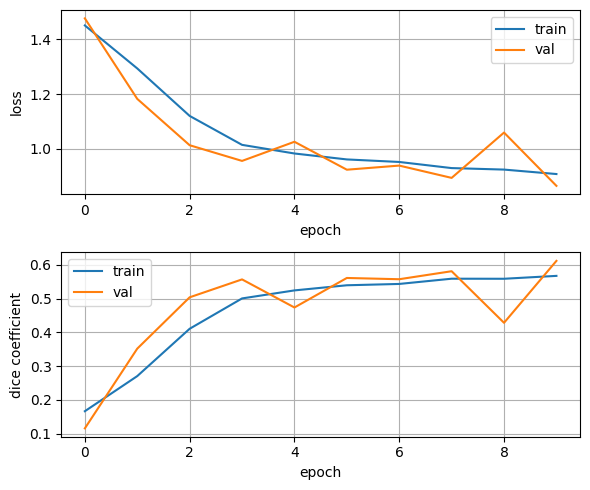

In [73]:
plt.figure(figsize=(6, 5))
plt.subplot(211)
plt.plot(train_loss, label="train")
plt.plot(val_loss,  label="val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid("on")
plt.legend()
plt.subplot(212)
plt.plot(train_dice_coefficient, label="train")
plt.plot(val_dice_coefficient, label="val")
plt.xlabel("epoch")
plt.ylabel("dice coefficient")
plt.grid("on")
plt.legend()
plt.tight_layout()

## 모델 Test

In [74]:
def load_model(ckpt_path, num_classes, device):
    checkpoint = torch.load(ckpt_path, map_location=device)
    model = UNet(num_classes=num_classes)
    model.load_state_dict(checkpoint)
    model = model.to(device)
    model.eval()  # test
    return model

In [76]:
ckpt_path = "/content/drive/MyDrive/Study/CV_fc/CV_project/human_segmentation/human_segmentation_model/model_09.pth"
model = load_model(ckpt_path, num_classes, DEVICE)

transformer = transforms.Compose([
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])